# Dark photon summary plots

This notebook makes summary plots from analytical rescalings of dijet resonance search limits for $Z'$ mediators in simplified dark matter models. The dark photon re-scaling relies on the methods defined in `modules/dark_photon.py` and ingests the output of that script.

In [1]:
# import useful packages
import mplhep as hep
import matplotlib.pyplot as plt
import json
import numpy as np
import matplotlib as mpl

In [2]:
import sys
sys.path.append("..")  # to allow imports from parent directory
from modules.benchmarks import benchmarks
from modules.dark_photon import calculate_epsilon, compute_yield_parameter

In [3]:
# this defines what inputs to use
inputs = [
    {
        "label": "ATLAS Run 2 Dijet TLA" + "\n" + "PRD 112, 092015 (2025)\n" + r"$\sqrt{s} = 13$ TeV, 140 fb$^{-1}$",
        "input_file_observed": ["../outputs/TLADijetRun2_J100_observed_darkPhoton.json", "../outputs/TLADijetRun2_J50_observed_darkPhoton.json"],
        "input_file_expected": ["../outputs/TLADijetRun2_J100_expected_darkPhoton.json", "../outputs/TLADijetRun2_J50_expected_darkPhoton.json"],
    },
    # configure more inputs here as needed
]

benchmark_name = "minimal_dark_photon"

# whether to annotate the plots with additional lines
annotate_plots = False
annotation_points = [
    {"gq": 0.03, "color": "darkred", "linestyle": (5, (10, 3)), "label": "$g_q = 0.03$"},
    {"gq": 0.02, "color": "darkslategrey", "linestyle": "-.", "label": "$g_q = 0.02$"},
    {"gq": 0.01, "color": "darkolivegreen", "linestyle": ":", "label": "$g_q = 0.01$"},
]

In [4]:
# define a method for plotting the reference points
def plot_reference_points(points:list, legend_handles:list, legend_labels:list, ax:mpl.axes.Axes, benchmark_name:str, linewidth:float=2.0):
    x_limit_min, x_limit_max = ax.get_xlim()
    mmed_ref = np.linspace(x_limit_min, x_limit_max, 1000)

    # get benchmark info
    gdm = benchmarks[benchmark_name]["parameters"]["gdm"]
    mdm_frac = benchmarks[benchmark_name]["parameters"]["mdm_fraction"]

    # plot the points and append info to the legend
    for point in points:
        y_ref = compute_yield_parameter(mmed_ref, mmed_ref * mdm_frac, np.ones_like(mmed_ref) * point["gq"], gdm=gdm)
        ax.plot(mmed_ref, y_ref, color=point["color"], linestyle=point["linestyle"], label=point["label"], linewidth=linewidth)
        legend_labels.append(point["label"])
        legend_handles.append(plt.Line2D([], [], color=point["color"], linestyle=point["linestyle"], linewidth=linewidth))

    return
    

In [5]:
def interpolate_limit(mass_vals:np.ndarray, limit_vals:np.ndarray, mass_min:float, mass_max:float, num_points:int=1000):
    """Interpolate limit values over a specified range of mass values."""
    mass_interp = np.linspace(mass_min, mass_max, num_points)
    limit_interp = np.interp(mass_interp, mass_vals, limit_vals)
    return mass_interp, limit_interp    

In [6]:
# this defines the plot style to use
# for now just use the ATLAS style (can be changed later)
hep.style.use("ATLAS")

In [7]:
# variables controlling interpolation
num_interp_points = 100
min_interp_mmed = 50 # GeV
max_interp_mmed = 750 # GeV
min_interp_mdm = 10 # GeV
max_interp_mdm = 250 # GeV

## Limits on yield parameter $y$ vs. dark photon mass

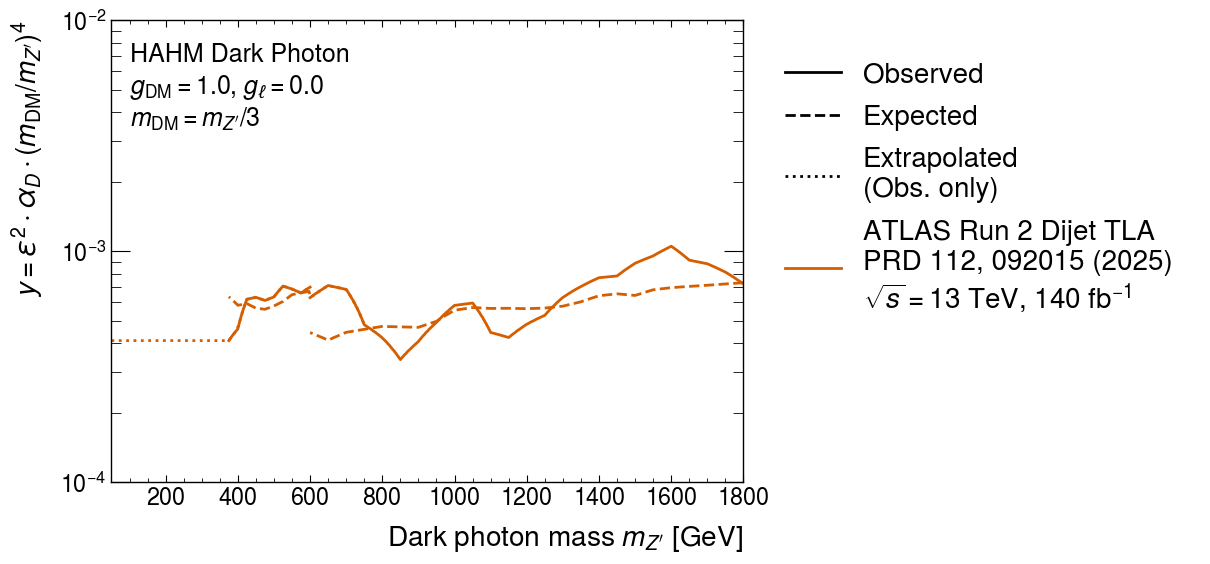

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
legend_handles = [
    plt.Line2D([], [], color="k", linestyle="-", lw=2),
    plt.Line2D([], [], color="k", linestyle="--", lw=2),
    plt.Line2D([], [], color="k", linestyle=":", lw=2),
]
legend_labels = [
    "Observed",
    "Expected",
    "Extrapolated\n(Obs. only)",
]

data_dict = dict()
all_mass = []
all_limits = []

for idx, input_cfg in enumerate(inputs):
    all_mass = []
    all_limits = []
    # add to legend handles and labels
    legend_labels.append(input_cfg["label"])
    legend_handles.append(plt.Line2D([], [], color=f"C{idx}", lw=2))
    for key, linestyle in [("input_file_observed", "-"), ("input_file_expected", "--")]:
        for file in input_cfg[key]:
            # load the data
            with open(file, "r") as f:
                data_dict = json.load(f)

            # extract the observed dark photon limits
            for mmed, y_lim in zip(data_dict["mmed"], data_dict["y_limit"]):
                if "observed" in key:
                    all_mass.extend(mmed)
                    all_limits.extend(y_lim)
        
                # plot the contours for the limit
                ax.plot(
                    mmed,
                    y_lim,
                    color=f"C{idx}",
                    lw=2,
                    linestyle=linestyle,
                )

    # interpolate the combined limits to lower mass
    all_mass = np.array(all_mass)
    all_limits = np.array(all_limits)
    # sort the arrays
    sorted_indices = np.argsort(all_mass)
    all_mass = all_mass[sorted_indices]
    all_limits = all_limits[sorted_indices]
    mass_interp, limits_interp = interpolate_limit(
        all_mass,
        all_limits,
        min_interp_mmed,
        max_interp_mmed,
        num_points=num_interp_points
    )

    # plot interpolated limits
    ax.plot(
        mass_interp,
        limits_interp,
        color=f"C{idx}",
        lw=2,
        linestyle=":",
    )

# format the plot
ax.set_yscale("log")
ax.set_xlim(50, 1800)
ax.set_xlabel(r"Dark photon mass $m_{Z'}$ [GeV]")
ax.set_ylabel(r"$y = \epsilon^2 \cdot \alpha_D \cdot (m_{\mathrm{DM}}/ m_{Z'})^4$")
ax.set_ylim(top=1e-2)

# annotations
if annotate_plots:
    plot_reference_points(annotation_points, legend_handles, legend_labels, ax, benchmark_name)
    ax.set_ylim(bottom=1e-7)

# add a legend
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    bbox_to_anchor=(1.0, 1.0),
    loc="upper left",
    labelspacing=0.6,
    fontsize=20
)

# setup plot text
plot_text = (
    benchmarks[benchmark_name]["name"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["coupling_label"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["mdm_label"]
)
_ = ax.text(
    0.03, 
    0.95, 
    plot_text, 
    transform=ax.transAxes, 
    fontsize=18, 
    va='top', 
    ha='left'
)
plt.savefig("../outputs/y_vs_mmed_summary_plot.pdf", bbox_inches='tight')

## Limits on yield parameter $y$ vs. dark matter mass

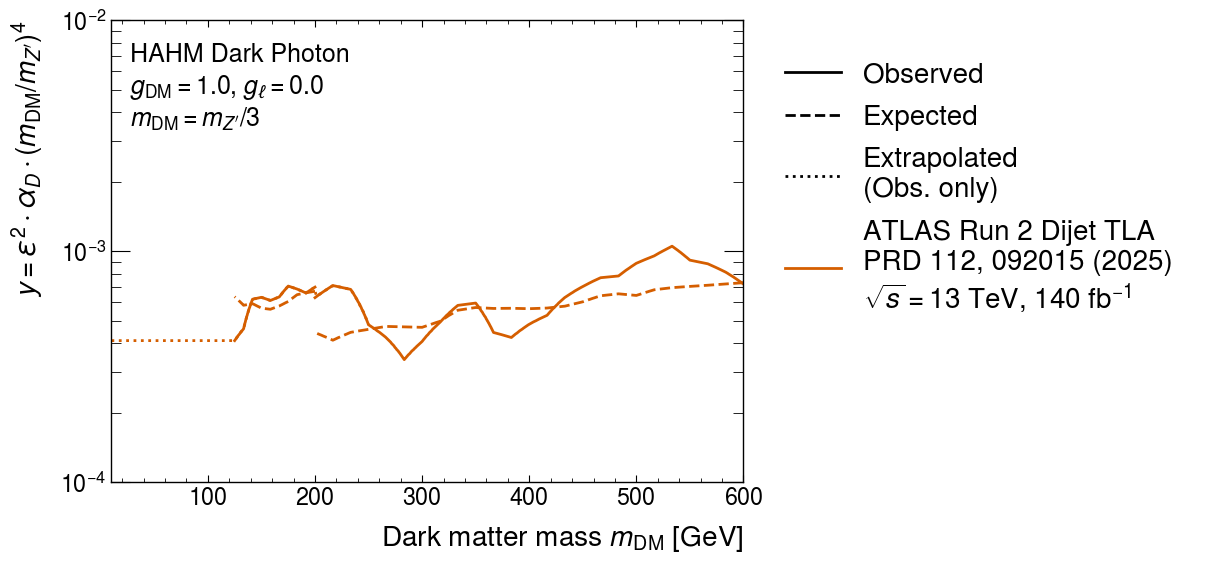

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
legend_handles = [
    plt.Line2D([], [], color="k", linestyle="-", lw=2),
    plt.Line2D([], [], color="k", linestyle="--", lw=2),
    plt.Line2D([], [], color="k", linestyle=":", lw=2),
]
legend_labels = [
    "Observed",
    "Expected",
    "Extrapolated\n(Obs. only)",
]

mdm_frac = benchmarks[benchmark_name]["parameters"]["mdm_fraction"]

data_dict = dict()
all_mass = []
all_limits = []

for idx, input_cfg in enumerate(inputs):
    all_mmed = []
    all_limits = []
    # add to legend handles and labels
    legend_labels.append(input_cfg["label"])
    legend_handles.append(plt.Line2D([], [], color=f"C{idx}", lw=2))

    for key, linestyle in [("input_file_observed", "-"), ("input_file_expected", "--")]:
        for file in input_cfg[key]:
            # load the data
            with open(file, "r") as f:
                data_dict = json.load(f)

            # extract the observed dark photon limits
            for mmed, y_lim in zip(data_dict["mmed"], data_dict["y_limit"]):
                if "observed" in key:
                    all_mass.extend((np.array(mmed) * mdm_frac).tolist())
                    all_limits.extend(y_lim)
                # plot the contours for the limit
                ax.plot(
                    np.array(mmed) * mdm_frac, # conversion to mdm
                    y_lim,
                    color=f"C{idx}",
                    lw=2,
                    linestyle=linestyle,
                )
    
    # interpolate the combined limits to lower mass
    all_mass = np.array(all_mass)
    all_limits = np.array(all_limits)
    # sort the arrays
    sorted_indices = np.argsort(all_mass)
    all_mass = all_mass[sorted_indices]
    all_limits = all_limits[sorted_indices]
    mass_interp, limits_interp = interpolate_limit(
        all_mass,
        all_limits,
        min_interp_mdm,
        max_interp_mdm,
        num_points=num_interp_points
    )

    # plot interpolated limits
    ax.plot(
        mass_interp,
        limits_interp,
        color=f"C{idx}",
        lw=2,
        linestyle=":",
    )

# format the plot
ax.set_yscale("log")
ax.set_xlim(10, 600)
ax.set_xlabel(r"Dark matter mass $m_{\mathrm{DM}}$ [GeV]")
ax.set_ylabel(r"$y = \epsilon^2 \cdot \alpha_D \cdot (m_{\mathrm{DM}}/ m_{Z'})^4$")
ax.set_ylim(top=1e-2)

# annotations
if annotate_plots:
    plot_reference_points(annotation_points, legend_handles, legend_labels, ax, benchmark_name)
    ax.set_ylim(bottom=1e-7)

# add a legend
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    bbox_to_anchor=(1.0, 1.0),
    loc="upper left",
    labelspacing=0.6,
    fontsize=20
)

# setup plot text
plot_text = (
    benchmarks[benchmark_name]["name"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["coupling_label"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["mdm_label"]
)
_ = ax.text(
    0.03, 
    0.95, 
    plot_text, 
    transform=ax.transAxes, 
    fontsize=18, 
    va='top', 
    ha='left'
)
plt.savefig("../outputs/y_vs_mdm_summary_plot.pdf", bbox_inches='tight')

## Limits on mixing parameter $\epsilon^2$ vs. dark matter mass

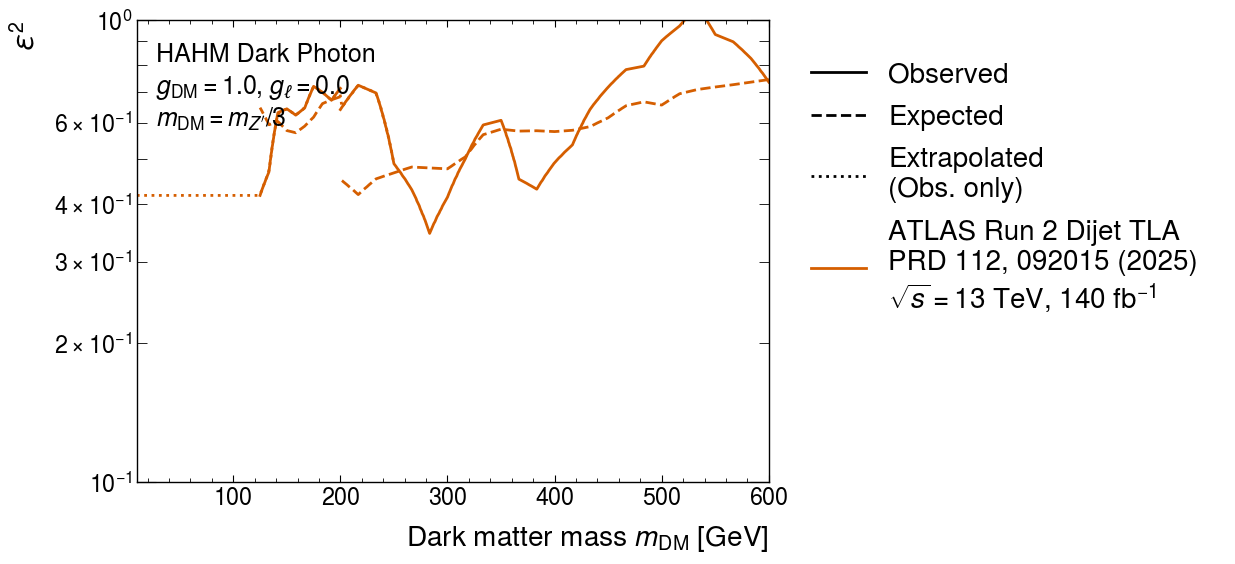

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
legend_handles = [
    plt.Line2D([], [], color="k", linestyle="-", lw=2),
    plt.Line2D([], [], color="k", linestyle="--", lw=2),
    plt.Line2D([], [], color="k", linestyle=":", lw=2),
]
legend_labels = [
    "Observed",
    "Expected",
    "Extrapolated\n(Obs. only)",
]

mdm_frac = benchmarks[benchmark_name]["parameters"]["mdm_fraction"]

data_dict = dict()
all_mass = []
all_limits = []

for idx, input_cfg in enumerate(inputs):
    all_mass = []
    all_limits = []

    # add to legend handles and labels
    legend_labels.append(input_cfg["label"])
    legend_handles.append(plt.Line2D([], [], color=f"C{idx}", lw=2))

    for key, linestyle in [("input_file_observed", "-"), ("input_file_expected", "--")]:
        for file in input_cfg[key]:
            # load the data
            with open(file, "r") as f:
                data_dict = json.load(f)

            # extract the observed dark photon limits
            for mmed, eps_lim in zip(data_dict["mmed"], data_dict["epsilon_limit"]):
                if "observed" in key:
                    all_mass.extend((np.array(mmed) * mdm_frac).tolist())
                    all_limits.extend((np.array(eps_lim)**2).tolist())
                # plot the contours for the limit
                ax.plot(
                    np.array(mmed) * mdm_frac, # conversion to mdm
                    np.array(eps_lim)**2,
                    color=f"C{idx}",
                    lw=2,
                    linestyle=linestyle,
                )
    
    # interpolate the combined limits to lower mass
    all_mass = np.array(all_mass)
    all_limits = np.array(all_limits)
    # sort the arrays
    sorted_indices = np.argsort(all_mass)
    all_mass = all_mass[sorted_indices]
    all_limits = all_limits[sorted_indices]
    mass_interp, limits_interp = interpolate_limit(
        all_mass,
        all_limits,
        min_interp_mdm,
        max_interp_mdm,
        num_points=num_interp_points
    )

    # plot interpolated limits
    ax.plot(
        mass_interp,
        limits_interp,
        color=f"C{idx}",
        lw=2,
        linestyle=":",
    )

# format the plot
ax.set_yscale("log")
ax.set_xlim(10, 600)
ax.set_xlabel(r"Dark matter mass $m_{\mathrm{DM}}$ [GeV]")
ax.set_ylabel(r"$\epsilon^2$")
ax.set_ylim(top=1e0)

# annotations
if annotate_plots:
    plot_reference_points(annotation_points, legend_handles, legend_labels, ax, benchmark_name)
    ax.set_ylim(bottom=1e-7)

# add a legend
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    bbox_to_anchor=(1.0, 1.0),
    loc="upper left",
    labelspacing=0.6,
    fontsize=20
)

# setup plot text
plot_text = (
    benchmarks[benchmark_name]["name"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["coupling_label"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["mdm_label"]
)
_ = ax.text(
    0.03, 
    0.95, 
    plot_text, 
    transform=ax.transAxes, 
    fontsize=18, 
    va='top', 
    ha='left'
)
plt.savefig("../outputs/eps_vs_mdm_summary_plot.pdf", bbox_inches='tight')

## Limits on mixing parameter $\epsilon^2$ vs. dark photon mass

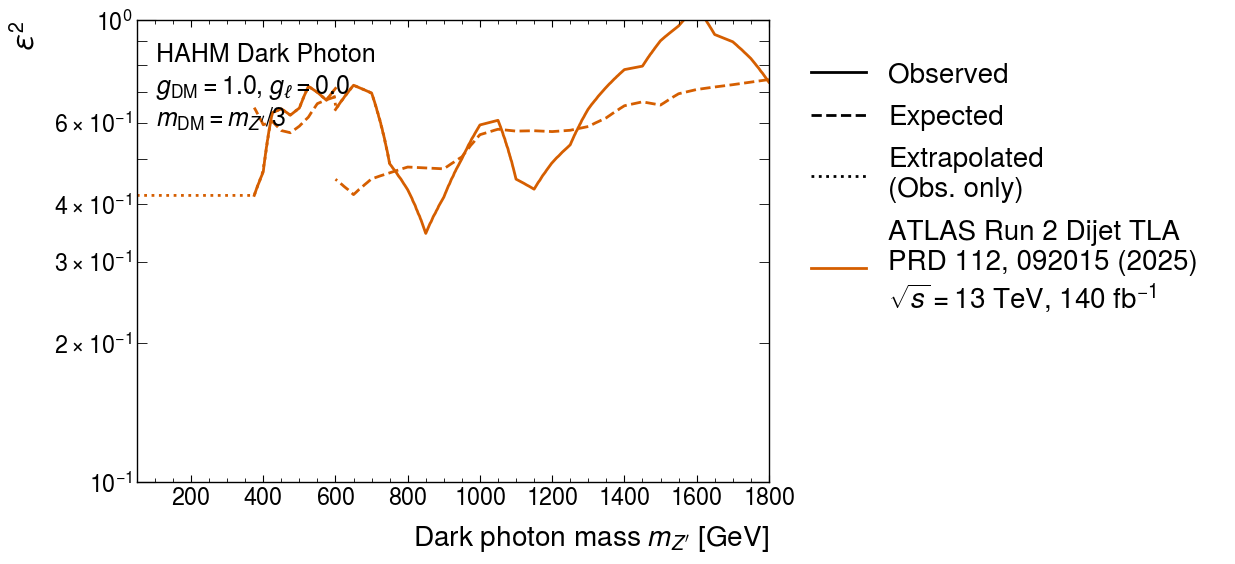

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
legend_handles = [
    plt.Line2D([], [], color="k", linestyle="-", lw=2),
    plt.Line2D([], [], color="k", linestyle="--", lw=2),
    plt.Line2D([], [], color="k", linestyle=":", lw=2),
]
legend_labels = [
    "Observed",
    "Expected",
    "Extrapolated\n(Obs. only)",
]

data_dict = dict()
all_mass = []
all_limits = []

for idx, input_cfg in enumerate(inputs):
    # add to legend handles and labels
    legend_labels.append(input_cfg["label"])
    legend_handles.append(plt.Line2D([], [], color=f"C{idx}", lw=2))

    for key, linestyle in [("input_file_observed", "-"), ("input_file_expected", "--")]:
        for file in input_cfg[key]:
            # load the data
            with open(file, "r") as f:
                data_dict = json.load(f)

            # extract the observed dark photon limits
            for mmed, eps_lim in zip(data_dict["mmed"], data_dict["epsilon_limit"]):
                if "observed" in key:
                    all_mass.extend(mmed)
                    all_limits.extend((np.array(eps_lim)**2).tolist())
                # plot the contours for the limit
                ax.plot(
                    mmed,
                    np.array(eps_lim)**2,
                    color=f"C{idx}",
                    lw=2,
                    linestyle=linestyle,
                )

    # interpolate the combined limits to lower mass
    all_mass = np.array(all_mass)
    all_limits = np.array(all_limits)
    # sort the arrays
    sorted_indices = np.argsort(all_mass)
    all_mass = all_mass[sorted_indices]
    all_limits = all_limits[sorted_indices]
    mass_interp, limits_interp = interpolate_limit(
        all_mass,
        all_limits,
        min_interp_mmed,
        max_interp_mmed,
        num_points=num_interp_points
    )

    # plot interpolated limits
    ax.plot(
        mass_interp,
        limits_interp,
        color=f"C{idx}",
        lw=2,
        linestyle=":",
    )

# format the plot
ax.set_yscale("log")
ax.set_xlim(50, 1800)
ax.set_xlabel(r"Dark photon mass $m_{Z'}$ [GeV]")
ax.set_ylabel(r"$\epsilon^2$")
ax.set_ylim(top=1e0)

# annotations
if annotate_plots:
    plot_reference_points(annotation_points, legend_handles, legend_labels, ax, benchmark_name)
    ax.set_ylim(bottom=1e-7)

# add a legend
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    bbox_to_anchor=(1.0, 1.0),
    loc="upper left",
    labelspacing=0.6,
    fontsize=20
)

# setup plot text
plot_text = (
    benchmarks[benchmark_name]["name"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["coupling_label"] + "\n" + 
    benchmarks[benchmark_name]["plot_parameters"]["mdm_label"]
)
_ = ax.text(
    0.03, 
    0.95, 
    plot_text, 
    transform=ax.transAxes, 
    fontsize=18, 
    va='top', 
    ha='left'
)
plt.savefig("../outputs/eps_vs_mmed_summary_plot.pdf", bbox_inches='tight')